# Classification des documents du procès des groupes américains du tabac

In [177]:
from time import time
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from pprint import pprint
import logging

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
def load_texts(path: str) -> (list, list):
    texts = []
    categories = []

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                with open(root + '/' + file, 'r', encoding="utf8") as text:
                    texts.append(text.read())
                    categories.append(root.split('/')[2])
    return texts, categories

In [4]:
def create_data_frame(texts: list, categories: list) -> pd.DataFrame:
     return pd.DataFrame({'text': texts, 'category': categories})

In [163]:
def plot_category_histogram(df: pd.DataFrame):
    plt.figure(figsize=(15, 5))
    plt.title("Number of texts by categories")
    sns.countplot(data=df, x='category')
    plt.show()

In [206]:
def print_average_number_words(df: pd.DataFrame):
    categories = np.unique(df.category)
    word_averages = []
    for category in categories:
        word_averages.append(np.mean(df[df.category == category].text.str.split().str.len()))
    plt.figure(figsize=(15, 5))
    plt.bar(categories, word_averages, color=cm.Paired.colors)
    plt.show()

In [49]:
def print_texts_examples(df: pd.DataFrame):
    categories = np.unique(df.category)
    texts = []
    for category in categories:
        texts.append([category, df[df.category == category][0:1].text.iloc[0]])
    print(tabulate(texts, headers=["Category", "text example"]))

In [6]:
def show_most_frequent_words(df: pd.DataFrame, method: str = 'bag_of_word', nb_features: int = 10, n_gram_range: tuple = (1, 1)):
    if method == 'bag_of_word':
        vectorizer = CountVectorizer(ngram_range=n_gram_range, max_features=nb_features)
        X = vectorizer.fit_transform(df.text)
        df_cv = pd.DataFrame(np.sum(X, axis=0), columns=vectorizer.get_feature_names())
        frequency_cv = df_cv.iloc[:, np.argsort(df_cv.loc[0])]
        print("Bag Of Word: word count with n-grams:", n_gram_range, "\n", frequency_cv.loc[0][::-1], "\n")
    elif method == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=nb_features)
        X = vectorizer.fit_transform(df.text)
        df_tf = pd.DataFrame(np.sum(X, axis=0), columns=vectorizer.get_feature_names())
        frequency_tf = df_tf.iloc[:, np.argsort(df_tf.loc[0])]
        print("TFIDF: word frequency\n", frequency_tf.loc[0][::-1], "\n")
    else:
        raise Exception('Wrong method')

       category  text
count      3482  3482
unique       10  3453
top        Memo      
freq        620    25 



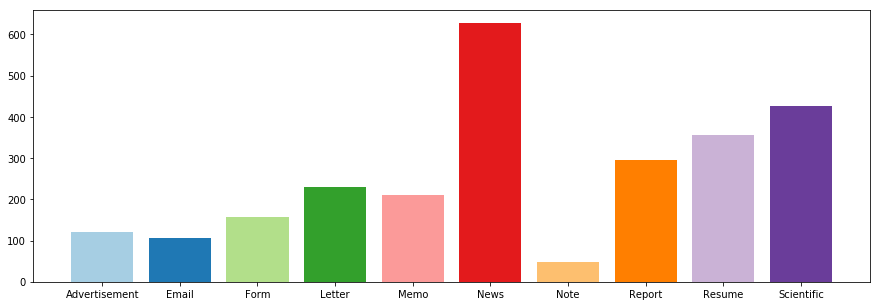

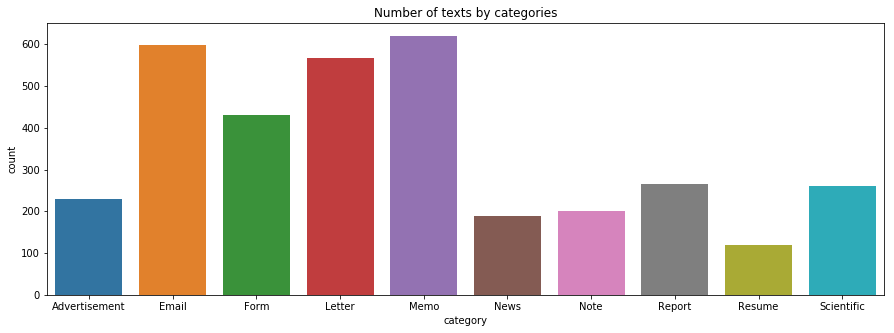

Category       text example
-------------  --------------------------------------------------------------------------------------------------------------------------------------------------
Advertisement  A Mpertant as yar
               sesiye teaetered cabiieess. Baely

               doesn’) keow bea te
               Bitton Aau-Fotne bl resin syste. Cant

               viduiiliy crafted. Parenter
               tiott, Most eapennese liste rn siichinng

               Holimars. Costlicr of course





               “Has Oetenined -

               Wainy: Thy
               ie Hoel? h.

               That Cia

               Marg a Féme awe ii na eager ref Hizon a ol





               Ra a

               6P9S70099
Email          Ellis, Cathy L. (WSA)



               From: Hsu, Frank

               Sent: Wednesday, March 24, 1999 10:58 AM
               Ta: Ellis, Cathy L. (WSA)

               Subject: RE: PLease review asap

               Cathy,

               My comments

Bag Of Word: word count with n-grams: (1, 1) 
 the     30607
of      20785
to      15492
and     14800
in      11391
for      6884
is       5376
that     4670
on       4525
be       4211
with     4133
from     4010
this     3831
by       3781
as       3209
are      2942
at       2693
or       2681
will     2610
we       2495
Name: 0, dtype: int64 



B:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


TFIDF: word frequency
 the     1312.183043
of       956.979566
to       881.827561
and      708.029248
in       557.484570
for      455.879180
from     434.994097
is       345.718885
on       345.057287
be       302.147471
this     280.492571
with     270.922698
that     270.542997
by       267.948819
we       262.764446
as       240.782882
will     230.662145
or       223.411988
are      223.118745
at       220.337021
Name: 0, dtype: float64 

Bag Of Word: word count with n-grams: (2, 2) 
 of the           4187
in the           2448
to the           1574
for the          1299
on the           1049
will be          1018
to be             870
new york          821
and the           768
philip morris     718
with the          718
that the          668
at the            668
by the            657
from the          643
has been          578
university of     522
it is             469
have been         462
of this           446
Name: 0, dtype: int64 



In [207]:
texts, categories = load_texts("data/Tobacco3482-OCR/")
df = create_data_frame(texts, categories)
print(df.describe(), "\n")
print_average_number_words(df)
plot_category_histogram(df)
print_texts_examples(df)
show_most_frequent_words(df, method='bag_of_word', nb_features=20)
show_most_frequent_words(df, method='tfidf', nb_features=20)
show_most_frequent_words(df, method='bag_of_word', nb_features=20, n_gram_range=(2, 2))

## Training and testing set splitting

In [111]:
# Split the dataset, create X (features) and y (target)
X_train, X_test, y_train, y_test = train_test_split(df.text, df.category, test_size=0.2)

In [301]:
# Hyperameters optimization with GridSearchCV = parallel processing
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__max_df': [0.1, 0.2],
    'vect__min_df': [0., 0.1],
    'vect__max_features': [1600, 1800, 2000],
    'clf__alpha': [0.10, 0.15, 0.20],
    'tfidf__use_idf': [True]
}
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=2, error_score=0)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': [0.1, 0.15, 0.2],
 'tfidf__use_idf': [True],
 'vect__max_df': [0.1],
 'vect__max_features': [1600, 1800, 2000],
 'vect__min_df': [0.0],
 'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]}
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.1min finished


done in 68.208s

Best score: 0.718
Best parameters set:
	clf__alpha: 0.15
	tfidf__use_idf: True
	vect__max_df: 0.1
	vect__max_features: 2000
	vect__min_df: 0.0
	vect__ngram_range: (1, 3)


B:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


## Bag of Word representation

In [112]:
# Create document vectors
vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=2000, min_df=0, max_df=0.1)
vectorizer.fit(X_train)
X_train_counts = vectorizer.transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# train a Naive Bayes classifier
clf = MultinomialNB(alpha=0.15)
clf.fit(X_train_counts, y_train)

y_hat_train_bw = clf.predict(X_train_counts)
error_train_bw = y_hat_train_bw[y_hat_train_bw == y_train].size / y_train.size

y_hat_test_bw = clf.predict(X_test_counts)
error_test_bw = y_hat_test_bw[y_hat_test_bw == y_test].size / y_test.size

table = [["training error", error_train_bw], ["test error", error_test_bw]]
print(tabulate(table))

--------------  --------
training error  0.824776
test error      0.734577
--------------  --------


               precision    recall  f1-score   support

Advertisement       0.70      0.58      0.64        48
        Email       0.96      0.92      0.94       124
         Form       0.68      0.71      0.70        89
       Letter       0.78      0.66      0.71       102
         Memo       0.68      0.86      0.76       115
         News       0.65      0.78      0.70        40
         Note       0.42      0.26      0.32        43
       Report       0.53      0.70      0.60        54
       Resume       1.00      1.00      1.00        27
   Scientific       0.81      0.62      0.70        55

  avg / total       0.74      0.73      0.73       697



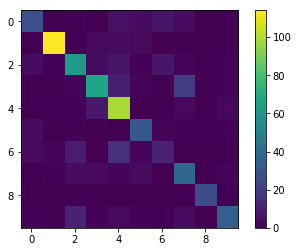

In [113]:
report = classification_report(y_test, y_hat_test_bw)
print(report)
confusion = confusion_matrix(y_test, y_hat_test_bw)
plt.imshow(confusion)
plt.colorbar()
plt.show()

In [219]:
display = pd.DataFrame(X_train_tf.toarray(), columns=vectorizer.get_feature_names())
display.iloc[0:5 , 500:510]

,country,county,coupon,coupons,course,court,cover,critical,cs,ct
0,0.068894,0.0,0.0,0.0,0.0,0.432446,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.057233,0.0,0.0


## TF-IDF representation

In [114]:
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_test_tf = tf_transformer.transform(X_test_counts)

# train a Naive Bayes classifier
clf = MultinomialNB(alpha=0.15)
clf.fit(X_train_tf, y_train)

y_hat_train_tf = clf.predict(X_train_tf)
error_train_tf = y_hat_train_tf[y_hat_train_tf == y_train].size / y_train.size

y_hat_test_tf = clf.predict(X_test_tf)
error_test_tf = y_hat_test_tf[y_hat_test_tf == y_test].size / y_test.size

table = [["training error", error_train_tf], ["test error", error_test_tf]]
print(tabulate(table))

--------------  --------
training error  0.828007
test error      0.733142
--------------  --------


B:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


               precision    recall  f1-score   support

Advertisement       0.76      0.65      0.70        48
        Email       0.96      0.92      0.94       124
         Form       0.69      0.76      0.72        89
       Letter       0.75      0.67      0.70       102
         Memo       0.61      0.87      0.72       115
         News       0.68      0.75      0.71        40
         Note       0.44      0.16      0.24        43
       Report       0.61      0.52      0.56        54
       Resume       1.00      1.00      1.00        27
   Scientific       0.76      0.69      0.72        55

  avg / total       0.73      0.73      0.72       697



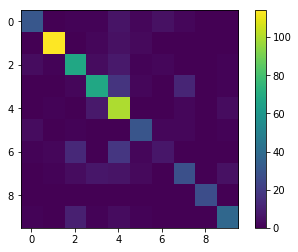

In [115]:
report = classification_report(y_test, y_hat_test_tf)
print(report)
confusion = confusion_matrix(y_test, y_hat_test_tf)
plt.imshow(confusion)
plt.colorbar()
plt.show()